In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time
import sys
import os
import networkx as nx
import re
import scipy.stats

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

from parliament.utils import merge_utterance_paragraphs

In [9]:
# function definitions for correlations and graph generation

user1 =  User.objects.get(username='muef')

def dfdt(qs):
    ## Make a queryset of doctopics into a pandas
    ## df in the format we want to used
    df = pd.DataFrame(qs)
    if 'topic_id' not in df.columns:
        df = df.rename(columns={
            'tc': 'score',
            'topic__topicdtopic__dynamictopic_id': 'topic_id'
        })
    return df

def correlate_topics(df, doc_id, method='pearson'):

    df = df.pivot(
        index=doc_id,
        columns='topic_id',
        values='score'
    ).fillna(0)

    corr = df.corr(method=method)
    #values = corr.values
    #cols = corr.columns
    
    if method is 'pearson':
        # calculate p-values for pearson correlation coefficient
        pvalues = calculate_pvalues(df)
    else:
        pvalues = None

    return corr, pvalues
    # end def correlate_topics

# to get p_values:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = scipy.stats.pearsonr(df[r], df[c])[1]
    return pvalues


def filter_occurrence(run_id, dts, filter_occurrence_no, party_name=None, period_list=None):
    stat = RunStats.objects.get(run_id=run_id)
    regular_expression = stat.psearch.text
    SEARCH = re.compile(regular_expression, re.IGNORECASE)

    print("filtering for speeches with {} or more occurrences of\n{}".format(filter_occurrence_no,
                                                                             regular_expression))
    pre_dts_len = len(dts)

    uts = pm.Utterance.objects.filter(search_matches=stat.psearch).order_by('id')
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    if period_list:
         uts = uts.filter(document__parlperiod__n__in=period_list)
    
    texts, docsizes, ids = merge_utterance_paragraphs(uts)

    selected_ut_ids = []
    for i, text in enumerate(texts):
        if len(SEARCH.findall(text)) >= filter_occurrence_no:
            selected_ut_ids.append(ids[i])

    dts = dts.filter(ut__id__in=selected_ut_ids)
    print("ids: filtered {} from {}, ratio: {}".format(len(selected_ut_ids), len(ids), len(selected_ut_ids)/len(ids)))
    print("dts: filtered {} from {}, ratio: {}".format(len(dts), pre_dts_len, len(dts)/pre_dts_len))
    
    return dts


# function for calculating a correlation measure based on co-occurrance of most prevalent topics

def event_synchronization(df, doc_id, norm='total', event_threshold=0.1):
    score_sums = df[['ut_id','score']].groupby('ut_id').sum()
    joined_df = df.join(score_sums, on='ut_id', rsuffix='_sum')

    # use threshold of 10 or 5 % of total scores to define event
    joined_df['event'] = (joined_df['score'] > event_threshold * joined_df['score_sum'])

    topics_times_docs = df.ut_id.unique().size * df.topic_id.unique().size
    print("events: {} of {} ({})".format(joined_df['event'].sum(), topics_times_docs, joined_df['event'].sum()/topics_times_docs))
    print("on average {} topics per document".format(joined_df['event'].sum() / df.ut_id.unique().size))
    
    if norm is 'nonzero':
        joined_df['neg_event'] = ~joined_df['event']
        joined_df.neg_event = joined_df.neg_event.astype(int)

        doc_topic_neg_df = joined_df.pivot(
                    index=doc_id,
                    columns='topic_id',
                    values='neg_event'
                    )

    joined_df.event = joined_df.event.astype(int)

    doc_topic_df = joined_df.pivot(
                index=doc_id,
                columns='topic_id',
                values='event'
                )
    
    dot_product = doc_topic_df.transpose().dot(doc_topic_df)
    
    if norm is 'total':
        event_sync = dot_product / df.ut_id.unique().size
    
    elif norm is 'nonzero':
        neg_dot_product = doc_topic_neg_df.transpose().dot(doc_topic_neg_df)
        non_negative_uts = df.ut_id.unique().size - neg_dot_product

        event_sync = dot_product / non_negative_uts
    else:
        print("norm keyword not known")
        return 0
    
    return event_sync

# function for calculating topic correlation
# with slicing by party and/or parliamentary periods

def corr_topics(run_id, party_name=None, period_list=None, filter_occurrence_no=0, method='pearson'):
    print("Calculating topic correlation for party {} and periods {} in run {}".format(party_name, period_list, run_id))
    stat = RunStats.objects.get(pk=run_id)
    s_id = stat.psearch.id

    if stat.psearch is not None:
        doc_id = 'ut_id'
        tars = DynamicTopicTimePeriodScores
    else:
        doc_id = 'doc_id'
        tars = DynamicTopicARScores

    if stat.method=="DT":
        periods = stat.periods.all()
        dts = DocTopic.objects.filter(
            topic__topicdtopic__dynamictopic__run_id=run_id,
            topic__topicdtopic__score__gt=0.05,
            score__gt=0.05
        )
        
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period_list:
            dts = dts.filter(ut__document__parlperiod__n__in=period_list)
        if filter_occurrence_no:
            dts = filter_occurrence(run_id, dts, filter_occurrence_no,
                                    party_name=party_name, period_list=period_list)
            
        dts = dts.values(
            doc_id,'topic__topicdtopic__dynamictopic_id'
        ).annotate(
            tc=Sum(F('score') * F('topic__topicdtopic__score'),
        )).values(
            doc_id,
            'topic__topicdtopic__dynamictopic_id',
            'tc'
        )

        df = dfdt(list(dts))

        obj = DynamicTopicCorr

    else:
        dts = DocTopic.objects.filter(run_id=run_id)
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period_list:
            dts = dts.filter(ut__document__parlperiod__n__in=period_list)
        if filter_occurrence_no:
            dts = filter_occurrence(run_id, dts, filter_occurrence_no,
                                    party_name=party_name, period_list=period_list)
            
        dts = dts.values(doc_id,'topic_id','score')
        
        df = dfdt(list(dts))

        tars = TopicARScores
        obj = TopicCorr

        if stat.query:
            periods = scoping.models.AR.objects.all()
        else:
            periods = stat.periods.all()

    #df = df.pivot(index='topic_id',columns='doc_id',values='scaled_score')

    # pseudo code for docwise:
    # There are 96 billion combinations, so need to limit
    # For each doc, compare with docs that have a topic_score > 0 of the
    # Largest topic in the doc.
    #obj.objects.filter(run_id=run_id,ar=ar['n']).delete()
    
    if method in ['pearson', 'spearman']:
        corr, pvalues = correlate_topics(df, doc_id, method=method)
    elif method is 'event_sync':
        corr = event_synchronization(df, doc_id)
        pvalues = 0
    else:
        print("method not available")
        return 0
    
    K = RunStats.objects.get(pk=run_id).K
    uts = pm.Utterance.objects.filter(search_matches__id=s_id)
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    
    print("filtered docs * K: {}".format(uts.count() * K))
    print("df shape: {}".format(df.shape))
    
    return corr, pvalues


def get_graph(corr, threshold):
    adjacency_matrix = corr.ge(threshold).values - np.identity(corr.shape[0])
    G = nx.from_numpy_array(adjacency_matrix)
    print(nx.info(G))
    
    topic_ids = list(corr.index)

    labels = {}
    top_words = {}
    ids = {}
    scores = {}
    for i, topic_id in enumerate(topic_ids):
        topic = Topic.objects.get(id=topic_id)
        labels[i] = topic.title
        ids[i] = topic.id
        #top_words[i] = ", ".join(topic.top_words)
        scores[i] = topic.score
        
    nx.set_node_attributes(G, labels, name="label")
    nx.set_node_attributes(G, ids, name="id")
    nx.set_node_attributes(G, scores, name="totalscores")

    nx.set_node_attributes(G, top_words, name="topwords")
    
    weights = {}
    for i in range(len(topic_ids)):
        for j in range(len(topic_ids)):
            weights[(i, j)] = float(corr.values[i][j])
    
    nx.set_edge_attributes(G, weights, "weight")

    return G
    
def show_matrix(m, topic_list=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(m)
    if topic_list:
        plt.xticks(np.arange(len(topic_list)), topic_list, rotation='vertical', fontsize=8)
        plt.yticks(np.arange(len(topic_list)), topic_list, fontsize=8)
    cbar = fig.colorbar(cax)
    plt.show()
    
def get_off_diagonal_elements(array):
    vals = array.astype(np.float)
    np.fill_diagonal(vals, np.nan)
    return vals[~np.isnan(vals)].flatten()
    
def corr_hist(corr, threshold_pct, bins=50, log=False, off_diagonal=True):
    if off_diagonal:
        vals = get_off_diagonal_elements(corr.values)
    else:
        vals = corr.values.flatten()
        
    threshold = np.percentile(vals, threshold_pct)
    print("threshold: {}".format(threshold))
    plt.hist(vals, bins=bins, log=log)
    return threshold    

def print_network_characteristics(graph):
# print basic characteristics of the filtered graph
    print("nodes: {}".format(graph.number_of_nodes()))
    print("links: {}".format(graph.number_of_edges()))
    print("directed: {}".format(graph.is_directed()))
    print("link density: {}".format(nx.density(graph)))

    

# functions to compute and visualize network measures
def compute_network_measures(G, all_global_measures=True, centrality_measures=False,
                             write_output_file=None, verbosity=1):

    print("computing network measures...")
    no_nodes = G.number_of_nodes()
    no_edges = G.number_of_edges()
    link_density = no_edges / no_nodes
    nx.set_node_attributes(G, dict(nx.degree(G)), 'degree')
    mean_degree = np.mean(list(nx.get_node_attributes(G, 'degree').values()))

    ccs = nx.clustering(G)
    mean_clustering_coefficient = sum(list(ccs.values())) / no_nodes

    list_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    nodes_in_largest_component = list_cc[0]
    # make copy to separate largest component of the graph
    G_p = G.copy()
    largest_component = sorted(nx.connected_components(G_p),
                               key=len, reverse=True)[0]
    node_list_old = list(G_p.nodes())
    for node in node_list_old:
        if not (node in largest_component):
            G_p.remove_node(node)

    if all_global_measures:
        print("calculating diameter...")
        diameter_largest_component = nx.diameter(G_p)
        print("calculating radius...")
        radius_largest_component = nx.radius(G_p)

    if centrality_measures:
        print("calculating betweenness centrality...")
        # betweenness centrality
        bnc = nx.betweenness_centrality(G_p)
        assert isinstance(bnc, dict)
        nx.set_node_attributes(G, bnc, 'betweennessc_largest_component')
        mean_betweennessc_largest_component = np.mean(list(bnc.values()))

        print("calculating eigenvector centrality...")
        # eigenvector centrality
        evc = nx.eigenvector_centrality(G_p)
        assert isinstance(evc, dict)
        nx.set_node_attributes(G, evc, 'eigenvectorc_largest_component')
        mean_eigenvectorc_largest_component = np.mean(list(evc.values()))

        print("calculating closeness centrality...")
        # closeness centrality
        clc = nx.closeness_centrality(G_p)
        assert isinstance(clc, dict)
        nx.set_node_attributes(G, clc, 'closenessc_largest_component')
        mean_closenessc_largest_component = np.mean(list(clc.values()))

    if verbosity > 0:
        print("Number of nodes: " + str(no_nodes))
        print("Number of edges: " + str(no_edges))
        print("Link density: " + str(link_density))
        print("Mean degree: " + str(mean_degree))
        print("Mean clustering coefficient: " + str(mean_clustering_coefficient))
        print("Connected components:", list_cc)

        if all_global_measures:
            print("Diameter of largest component: " + str(diameter_largest_component))
            print("Radius of largest component: " + str(radius_largest_component))

        if centrality_measures:
            print("Mean betweenness centrality (of largest component): "
                  + str(mean_betweennessc_largest_component))

            print("Mean eigenvector centrality (of largest component): "
                  + str(mean_eigenvectorc_largest_component))

            print("Mean closeness centrality (of largest component) "
                  + str(mean_closenessc_largest_component))

    if write_output_file:
        f = open(write_output_file, "w")
        f.write("Network measures for spatial graph\n")
        f.write("\nNumber of nodes: " + str(no_nodes))
        f.write("\nNumber of edges: " + str(no_edges))
        f.write("\nLink density: " + str(link_density))
        f.write("\nMean degree: " + str(mean_degree))
        f.write("\nMean clustering coefficient: " + str(mean_clustering_coefficient))
        f.write("\nConnected components: " + str(list_cc))

        if all_global_measures:
            f.write("\nDiameter of largest component: " + str(diameter_largest_component))
            f.write("\nRadius of largest component: " + str(radius_largest_component))

        if centrality_measures:
            f.write("\nMean betweenness centrality (of largest component): "
                    + str(mean_betweennessc_largest_component))

            f.write("\nMean eigenvector centrality (of largest component): "
                    + str(mean_eigenvectorc_largest_component))

            f.write("\nMean closeness centrality (of largest component) "
                    + str(mean_closenessc_largest_component))

        f.close()

    return 0


def plot_network_centrality_histograms(G, figure_file_path, log=False, normalized=True, no_bins=50):

    if 'betweennessc_largest_component' not in G.node[1]:
        compute_network_measures(G, centrality_measures=True, all_global_measures=False, verbosity=0)

    fig, ax = plt.subplots(4, figsize=(6, 8))

    degrees = dict(nx.get_node_attributes(G, 'degree'))
    # show degree distribution
    ax[0].hist(list(degrees.values()), bins=no_bins, normed=normalized)
    ax[0].set_title("degree histogram")

    betweennessc = dict(nx.get_node_attributes(G, 'betweennessc_largest_component'))
    ax[1].hist(list(betweennessc.values()), bins=no_bins, normed=normalized)
    ax[1].set_title("betweenness centrality histrogram")

    eigenvectorc = dict(nx.get_node_attributes(G, 'eigenvectorc_largest_component'))
    ax[2].hist(list(eigenvectorc.values()), bins=no_bins, normed=normalized)
    ax[2].set_title("eigenvector centrality histogram")

    closenessc = dict(nx.get_node_attributes(G, 'eigenvectorc_largest_component'))
    ax[3].hist(list(closenessc.values()), bins=no_bins, normed=normalized)
    ax[3].set_title("closeness centrality histrogram")

    if log:
        for axis in ax:
            axis.set_yscale('log', nonposy='clip')

    plt.tight_layout()
    fig.savefig(figure_file_path)
    print("saved figure to " + figure_file_path)

# generate and save graphs

In [10]:
run_id = 2350

save_dir = '../plots/topic_analysis_{}/topic_correlations/'.format(run_id)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [11]:
# get topic scores per period
dts = DocTopic.objects.filter(run_id=run_id)
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_period_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_period_scores

# get topic scores per party
topic_period_scores = dts.values('topic__title','ut__speaker__party__name').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'party']
df_party_scores = df.pivot(index='party', columns='topic', values='score')
df_party_scores

topic,European Coal & Steel Community,agricultural policy,budget,budget 2,climate protection,coal mining,coal policy & prices,common terms,debate government policy,economic policy,...,policy statements,procedural,procedural 2,research & development,reunification,risks of nuclear energy,structural adjustment,subsidy reduction,tax policy,transport policy
party,,,,,,,,,,,,,,,,,,,,,
NaN,1996.303334,1154.485497,2662.623730,1377.093843,1040.432323,705.481074,2595.012813,9255.844508,725.215314,4354.258574,...,1657.107667,8612.083514,1284.784088,1819.744165,1683.423501,1761.385919,1493.439199,1538.412836,1350.924676,1132.859553
afd,75.727338,16.892710,84.218820,37.884908,1677.816751,0.710000,23.897695,1580.727233,2565.474998,335.120402,...,193.749000,119.692469,20.533711,98.348674,232.816838,246.868783,170.059286,252.880612,231.469484,126.128306
bp,652.347775,0.080000,14.103082,4.848991,1.326530,0.080000,137.410643,281.978064,0.080000,73.914542,...,98.265563,342.034997,0.080000,0.080000,2.974672,0.080000,59.578484,0.080000,2.860608,0.080000
cducsu,52852.691823,28184.476551,83636.980459,43045.346905,24396.418538,23081.588120,42384.725873,146119.282769,12468.288267,95747.893250,...,80811.777303,153504.727782,50885.189117,26401.252905,23514.434376,31744.121727,17746.449382,22049.819565,29120.454911,40199.975003
dp,2681.978035,219.278004,158.401585,5.064760,0.210000,6.328806,460.583522,1049.911657,3.430666,1251.470292,...,339.046355,971.423004,43.106205,92.227988,32.263680,7.738184,123.515487,8.079797,71.018868,188.380337
drp,1330.411104,0.030000,0.030000,0.030000,0.030000,0.030000,16.576617,731.964228,0.030000,85.196317,...,97.630348,288.832941,0.030000,0.030000,3.393664,0.030000,0.030000,0.030000,0.030000,0.030000
dzp,2382.989321,415.370631,461.108061,36.589563,2.613395,88.633873,2161.138312,1326.105167,7.279751,2027.729374,...,68.808178,669.815031,5.492825,21.617248,9.665940,12.339114,80.135743,5.866052,1057.634671,331.745521
fdp,13628.057114,9972.827975,17123.125652,12973.842036,8926.626487,6751.257765,12322.273907,66774.255585,6639.333036,42640.588962,...,14953.620152,65223.030654,18572.122387,6948.788231,7835.333767,7336.047646,6329.964838,16439.008883,9473.509051,8862.505574
fraktionslos,4.296117,0.010000,0.010000,0.010000,67.541040,1.383701,0.010000,0.010000,0.010000,0.010000,...,0.010000,19.427981,0.010000,0.010000,44.111117,0.010000,0.010000,0.010000,0.010000,0.010000


Calculating topic correlation for party None and periods None in run 2350
events: 28790 of 320845 (0.0897318019604482)
on average 3.1406130686156866 topics per document
filtered docs * K: 320845
df shape: (320845, 3)


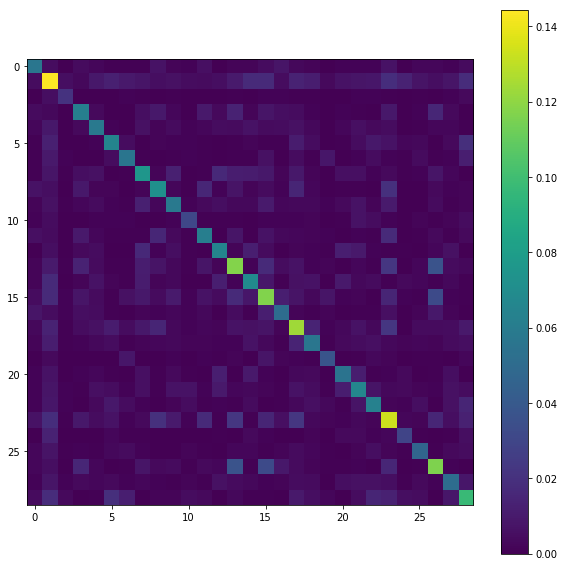

threshold: 0.006436129595287444
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 83
Average degree:   5.7241
saved graph in ./plots/topic_analysis_2350/topic_correlations/topic_correlations_run2350_all_pct80_event_sync.graphml


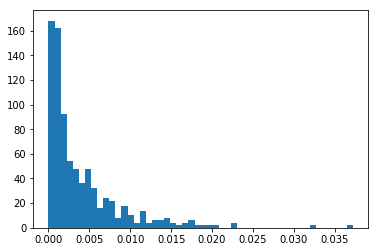

In [14]:
# generate graph for all documents

correlation_method = 'event_sync' #'spearman'

new_labels = False
threshold0 = False
percentile = 80
filter_occurrence_no = None
wo_procedural = True

corr, pvalues = corr_topics(run_id,
                            filter_occurrence_no=filter_occurrence_no,
                            method=correlation_method)

if wo_procedural:
    topic_dir = "../plots/topic_analysis_{}/".format(run_id)
    topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
    procedural_topic_ids = topic_classification[topic_classification['classification'] == 'procedural and general politics'].index
    procedural_topic_ids

    corr = corr.drop(procedural_topic_ids, axis=0)
    corr = corr.drop(procedural_topic_ids, axis=1)

show_matrix(corr.replace(to_replace=1, value=0))

if threshold0:
    G = get_graph(corr, 0)
else:
    threshold = corr_hist(corr, percentile)
    G = get_graph(corr, threshold)

if new_labels:
    node_labels = {}
    topic_ids = nx.get_node_attributes(G, 'id')
    for node_id, topic_id in topic_ids.items():
        node_labels[node_id] = labels[topic_id]

    nx.set_node_attributes(G, node_labels, 'label')

if threshold0:
    filename = os.path.join(save_dir, 'topic_correlations_run{}_all_threshold0_{}.graphml'.format(run_id, correlation_method))
else:
    filename = os.path.join(save_dir,
                            'topic_correlations_run{}_all_pct{}_{}.graphml'.format(run_id,
                                                                                        percentile, correlation_method))

nx.write_graphml(G, filename)
print("saved graph in {}".format(filename))

Calculating topic correlation for party spd and periods [12, 13, 14, 15, 16, 17, 18, 19] in run 2350
events: 3105 of 33670 (0.09221859221859222)
on average 3.227650727650728 topics per document
filtered docs * K: 89075
df shape: (33670, 3)


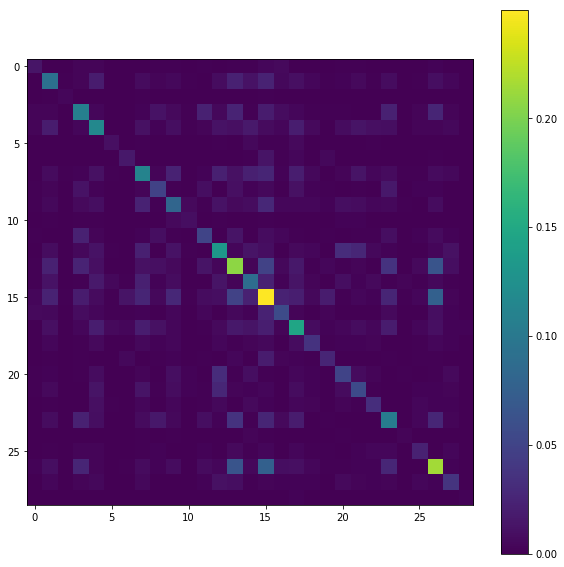

threshold: 0.006237006237006237
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 91
Average degree:   6.2759
saved graph in ./plots/topic_analysis_2350/topic_correlations/topic_correlations_run2350_party_spd_pct80_event_sync_1990.graphml
Calculating topic correlation for party cducsu and periods [12, 13, 14, 15, 16, 17, 18, 19] in run 2350
events: 4066 of 43995 (0.0924195931355836)
on average 3.2346857597454255 topics per document
filtered docs * K: 112805
df shape: (43995, 3)


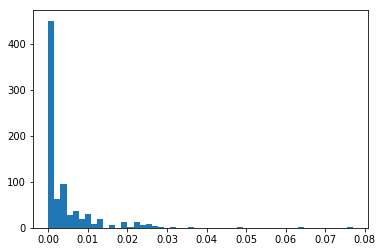

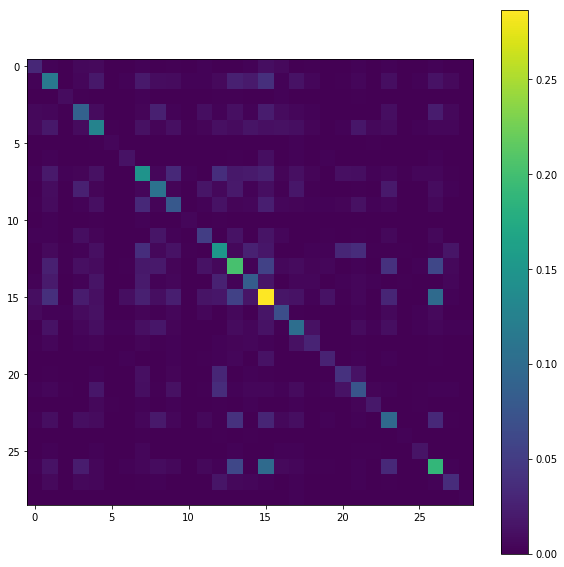

threshold: 0.006364359586316627
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 89
Average degree:   6.1379
saved graph in ./plots/topic_analysis_2350/topic_correlations/topic_correlations_run2350_party_cducsu_pct80_event_sync_1990.graphml
Calculating topic correlation for party fdp and periods [12, 13, 14, 15, 16, 17, 18, 19] in run 2350
events: 2202 of 23590 (0.09334463755828741)
on average 3.2670623145400595 topics per document
filtered docs * K: 51835
df shape: (23590, 3)


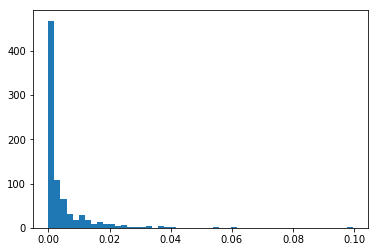

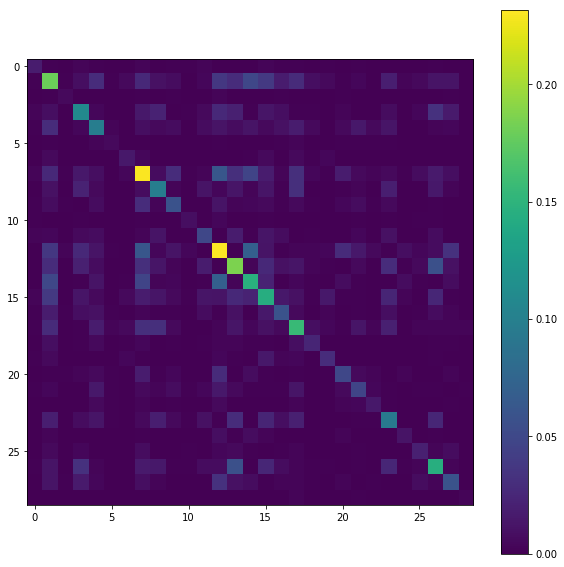

threshold: 0.007418397626112759
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 90
Average degree:   6.2069
saved graph in ./plots/topic_analysis_2350/topic_correlations/topic_correlations_run2350_party_fdp_pct80_event_sync_1990.graphml
Calculating topic correlation for party linke and periods [12, 13, 14, 15, 16, 17, 18, 19] in run 2350
events: 1283 of 14455 (0.08875821515046696)
on average 3.1065375302663436 topics per document
filtered docs * K: 14560
df shape: (14455, 3)


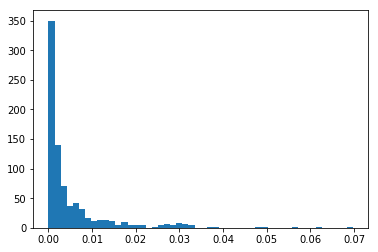

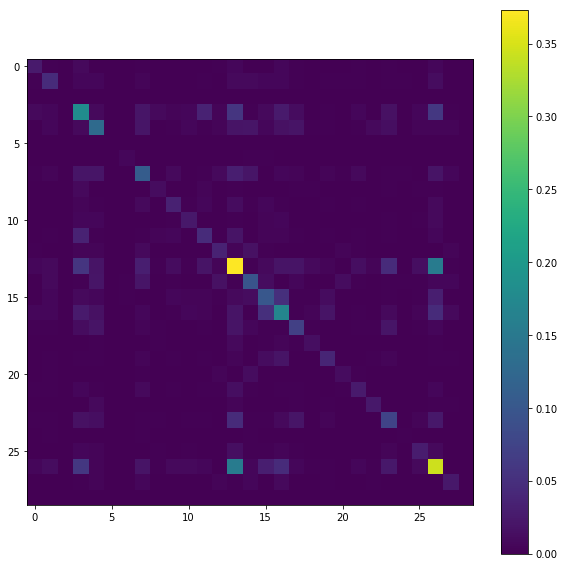

threshold: 0.004842615012106538
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 101
Average degree:   6.9655
saved graph in ./plots/topic_analysis_2350/topic_correlations/topic_correlations_run2350_party_linke_pct80_event_sync_1990.graphml
Calculating topic correlation for party gruene and periods [12, 13, 14, 15, 16, 17, 18, 19] in run 2350
events: 2586 of 28455 (0.09088033737480232)
on average 3.180811808118081 topics per document
filtered docs * K: 34405
df shape: (28455, 3)


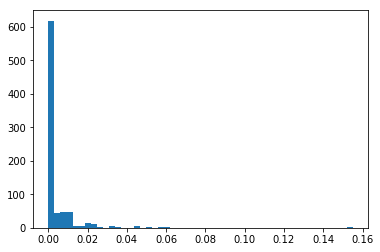

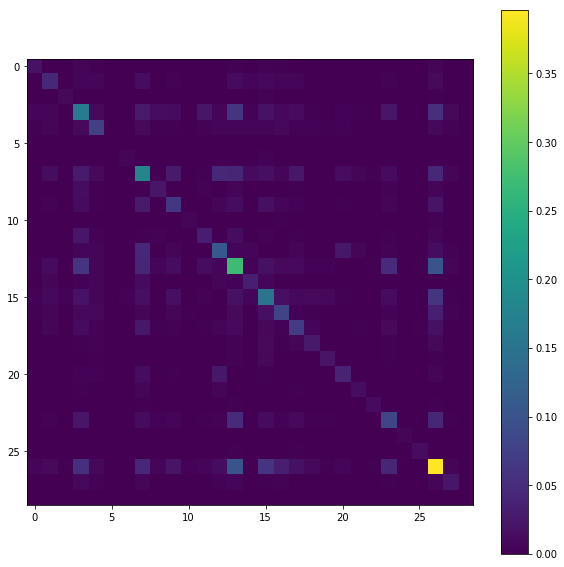

threshold: 0.003690036900369003
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 107
Average degree:   7.3793
saved graph in ./plots/topic_analysis_2350/topic_correlations/topic_correlations_run2350_party_gruene_pct80_event_sync_1990.graphml


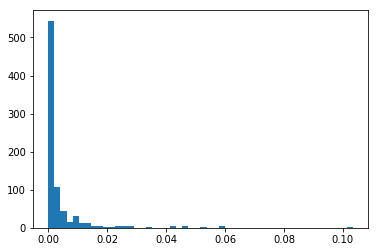

In [52]:
# generate graphs for parties

correlation_method = 'event_sync' #'spearman'

new_labels = False
threshold0 = False
percentile = 80
filter_occurrence_no = None

for party_name in ['spd', 'cducsu', 'fdp', 'linke', 'gruene']:

    corr, pvalues = corr_topics(run_id,
                                party_name=party_name,
                                period_list=[12, 13, 14, 15, 16, 17, 18, 19],
                                filter_occurrence_no=filter_occurrence_no,
                                method=correlation_method)
    # start from 1990, i.e. 12th parliamentary period
    
    if wo_procedural:
        topic_dir = "../plots/topic_analysis_{}/".format(run_id)
        topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
        procedural_topic_ids = topic_classification[topic_classification['classification'] == 'procedural and general politics'].index
        procedural_topic_ids

        corr = corr.drop(procedural_topic_ids, axis=0)
        corr = corr.drop(procedural_topic_ids, axis=1)
    
    show_matrix(corr.replace(to_replace=1, value=0))

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, percentile)
        G = get_graph(corr, threshold)
    
    if party_name:
        scores = {}
        topic_labels = nx.get_node_attributes(G, 'label')
        for node_id, topic_label in topic_labels.items():
            scores[node_id] = float(df_party_scores[topic_label][party_name])
            
        nx.set_node_attributes(G, scores, 'totalscores') 

    if new_labels:
        node_labels = {}
        topic_ids = nx.get_node_attributes(G, 'id')
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
        
        nx.set_node_attributes(G, node_labels, 'label') 
    
    if threshold0:
        filename = os.path.join(save_dir, 'topic_correlations_run{}_party_{}_threshold0_1990.graphml'.format(run_id, party_name))
    else:
        filename = os.path.join(save_dir,
                                'topic_correlations_run{}_party_{}_pct{}_{}_1990.graphml'.format(run_id, party_name,
                                                                                            percentile, correlation_method))

    nx.write_graphml(G, filename)
    print("saved graph in {}".format(filename))

topic_id,184079,184080,184081,184082,184083,184084,184085,184086,184087,184088,...,184104,184105,184106,184107,184108,184109,184110,184111,184112,184113
topic_id,,,,,,,,,,,,,,,,,,,,,
184079,1.000000,NaN,NaN,NaN,0.056056,NaN,NaN,NaN,NaN,0.070726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184080,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.083337,NaN,...,NaN,NaN,NaN,NaN,-0.050162,NaN,NaN,0.106517,NaN,-0.054617
184081,NaN,NaN,1.000000,0.240011,-0.053327,0.050285,0.227982,0.217756,NaN,NaN,...,0.115656,0.139817,0.241057,0.167057,0.161734,0.399617,0.144767,-0.080253,0.136637,0.227572
184082,NaN,NaN,0.240011,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.125620,0.097348,NaN,0.056327,NaN,NaN,0.056008,NaN
184083,0.056056,NaN,-0.053327,NaN,1.000000,NaN,-0.055768,NaN,NaN,0.148609,...,NaN,NaN,NaN,-0.053894,NaN,NaN,NaN,0.097362,NaN,-0.061008
184084,NaN,NaN,0.050285,NaN,NaN,1.000000,NaN,NaN,0.063009,NaN,...,NaN,0.066257,NaN,NaN,NaN,NaN,NaN,-0.053582,NaN,-0.049946
184085,NaN,NaN,0.227982,NaN,-0.055768,NaN,1.000000,NaN,-0.049473,NaN,...,NaN,NaN,NaN,0.054041,0.063817,NaN,NaN,-0.070256,NaN,0.319587
184086,NaN,NaN,0.217756,NaN,NaN,NaN,NaN,1.000000,NaN,-0.052844,...,NaN,0.154927,NaN,NaN,NaN,NaN,0.055147,NaN,NaN,0.120097
184087,NaN,0.083337,NaN,NaN,NaN,0.063009,-0.049473,NaN,1.000000,NaN,...,0.057232,NaN,NaN,NaN,-0.070049,NaN,NaN,NaN,NaN,-0.059777


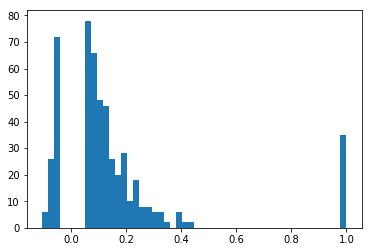

In [36]:
# show number / ratio of significant correlation values
alpha = 0.99
no_significant = pvalues[pvalues < 1 - alpha].count().sum()
print(no_significant)
print(no_significant / pvalues.size)

# filter with significance
values = corr[pvalues < 0.001].values.flatten()
plt.hist(values[~np.isnan(values)], bins=50)
corr[pvalues < 0.001]

Calculating topic correlation for party None and periods [1, 2, 3, 4, 5] in run 2350
events: 5947 of 67935 (0.0875395598734084)
on average 3.063884595569294 topics per document
filtered docs * K: 320845
df shape: (67935, 3)
threshold: 0.002575991756826378
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 97
Average degree:   6.6897
saved graph in ./plots/topic_analysis_2350/topic_correlations/topic_correlations_run2350_period_1-5_pct80_event_sync.graphml
Calculating topic correlation for party None and periods [6, 7, 8, 9, 10, 11] in run 2350
events: 9013 of 102550 (0.08788883471477328)
on average 3.076109215017065 topics per document
filtered docs * K: 320845
df shape: (102550, 3)
threshold: 0.005460750853242321
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 86
Average degree:   5.9310
saved graph in ./plots/topic_analysis_2350/topic_correlations/topic_correlations_run2350_period_6-11_pct80_event_sync.graphml
Calculating topic correlation for party None and periods [12,

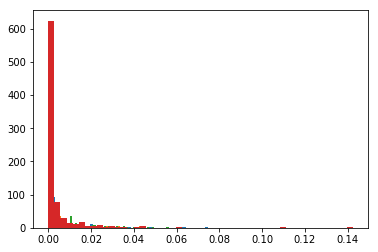

In [53]:
# generate graphs for sets of parliamentary periods

new_labels = False
threshold0 = False
percentile = 80
wo_procedural = True

period_sets = [[1,2,3,4,5], [6,7,8,9,10,11], [12, 13, 14, 15], [16, 17, 18, 19]]

for periods in period_sets:

    corr, pvalues = corr_topics(run_id,
                       period_list=periods,
                       filter_occurrence_no=None,
                       method=correlation_method)
    
    if wo_procedural:
        topic_dir = "../plots/topic_analysis_{}/".format(run_id)
        topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
        procedural_topic_ids = topic_classification[topic_classification['classification'] == 'procedural and general politics'].index
        procedural_topic_ids

        corr = corr.drop(procedural_topic_ids, axis=0)
        corr = corr.drop(procedural_topic_ids, axis=1)

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, percentile)
        G = get_graph(corr, threshold)
    
    topic_ids = nx.get_node_attributes(G, 'id')
    
    scores = {}
    topic_labels = nx.get_node_attributes(G, 'label')
    for node_id, topic_label in topic_labels.items():
        scores[node_id] = float(df_period_scores[topic_label][periods].sum())
        
    nx.set_node_attributes(G, scores, 'totalscores')
    
    if new_labels:
        node_labels = {}
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
            
        nx.set_node_attributes(G, node_labels, 'label')
    
    filename = os.path.join(save_dir, 'topic_correlations_run{}_period_{}-{}_pct{}_{}.graphml'.format(run_id,
                                                                            min(periods), max(periods), percentile,
                                                                            correlation_method))
    nx.write_graphml(G, filename)
    print("saved graph in {}".format(filename))

Calculating topic correlation for party spd and period None in run 1739
filtered docs * K: 29520
df shape: (29520, 3)
threshold: 0.06944110454687229
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 80
Average degree:   4.0000


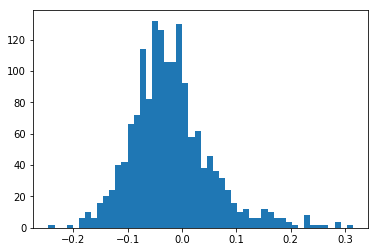

In [10]:
# test correlation threshold

corr = corr_topics(1739, party_name='spd')

threshold = corr_hist(corr, 90)

G = get_graph(corr, threshold)

In [170]:
%%bash
zip -r ../plots/topic_analysis_2350.zip plots/topic_analysis_2350

updating: plots/topic_analysis_2350/ (stored 0%)
updating: plots/topic_analysis_2350/0_topic_list_run2350_labeled.csv (deflated 70%)
updating: plots/topic_analysis_2350/0_topic_list+peak_topwords_run2350.xlsx (deflated 5%)
updating: plots/topic_analysis_2350/.ipynb_checkpoints/ (stored 0%)
updating: plots/topic_analysis_2350/topic_evolution_run2350_aggregate.png (deflated 6%)
updating: plots/topic_analysis_2350/party_proportions_run_2350_selection.png (deflated 33%)
updating: plots/topic_analysis_2350/topic_evolution_shares_run2350_wo_procedural_barplot_simple.png (deflated 19%)
updating: plots/topic_analysis_2350/topic_evolution_scores_run2350_all.png (deflated 10%)
updating: plots/topic_analysis_2350/topic_evolution_shares_run2350_all.png (deflated 9%)
updating: plots/topic_analysis_2350/time+party/ (stored 0%)
updating: plots/topic_analysis_2350/time+party/party_scores_run_2350_topic_184087.png (deflated 24%)
updating: plots/topic_analysis_2350/time+party/party_proportions_run_2350_

# testing and old code

In [23]:
for node_id, attr in G_party.nodes(data=True):
    print(node_id, attr)

0 {'label': 'environmental protection', 'id': 184079, 'totalscores': 147.722803398875}
1 {'label': 'debate government policy', 'id': 184080, 'totalscores': 2565.47499831048}
2 {'label': 'economic policy', 'id': 184081, 'totalscores': 335.120402217308}
3 {'label': 'agricultural policy', 'id': 184082, 'totalscores': 16.8927096181933}
4 {'label': 'green policies', 'id': 184083, 'totalscores': 91.1684108298073}
5 {'label': 'reunification', 'id': 184084, 'totalscores': 232.816837906663}
6 {'label': 'coal mining', 'id': 184085, 'totalscores': 0.71}
7 {'label': 'European Coal and Steel Community', 'id': 184086, 'totalscores': 75.7273378843524}
8 {'label': 'subsidy reduction', 'id': 184087, 'totalscores': 252.880612189229}
9 {'label': 'nuclear phase-out', 'id': 184088, 'totalscores': 306.375449281092}
10 {'label': 'stop words', 'id': 184089, 'totalscores': 1580.7272333005}
11 {'label': 'procedural', 'id': 184090, 'totalscores': 119.692468628946}
12 {'label': 'research & development', 'id': 184

In [14]:
list(G_party.nodes(data=True))

[('0',
  {'id': 184079,
   'label': 'environmental protection',
   'totalscores': 147.722803398875}),
 ('1',
  {'id': 184080,
   'label': 'debate government policy',
   'totalscores': 2565.47499831048}),
 ('2',
  {'id': 184081, 'label': 'economic policy', 'totalscores': 335.120402217308}),
 ('3',
  {'id': 184082,
   'label': 'agricultural policy',
   'totalscores': 16.8927096181933}),
 ('4',
  {'id': 184083, 'label': 'green policies', 'totalscores': 91.1684108298073}),
 ('5',
  {'id': 184084, 'label': 'reunification', 'totalscores': 232.816837906663}),
 ('6', {'id': 184085, 'label': 'coal mining', 'totalscores': 0.71}),
 ('7',
  {'id': 184086,
   'label': 'European Coal and Steel Community',
   'totalscores': 75.7273378843524}),
 ('8',
  {'id': 184087,
   'label': 'subsidy reduction',
   'totalscores': 252.880612189229}),
 ('9',
  {'id': 184088,
   'label': 'nuclear phase-out',
   'totalscores': 306.375449281092}),
 ('10', {'id': 184089, 'label': 'stop words', 'totalscores': 1580.72723

In [15]:
list(G_party.edges(data=True))

[('0', '12', {'weight': 0.5924275907439535}),
 ('0', '20', {'weight': 0.348280020535281}),
 ('0', '25', {'weight': 0.3515090429143934}),
 ('0', '28', {'weight': 0.3988510033440545}),
 ('1', '3', {'weight': 0.3322826737052749}),
 ('1', '5', {'weight': 0.29464615944632394}),
 ('1', '15', {'weight': 0.24572153968036575}),
 ('1', '18', {'weight': 0.22087003051493334}),
 ('1', '21', {'weight': 0.3035868979117506}),
 ('1', '23', {'weight': 0.1932920278081769}),
 ('1', '30', {'weight': 0.17948873340948313}),
 ('1', '33', {'weight': 0.208714088460816}),
 ('2', '3', {'weight': 0.2174454488233128}),
 ('2', '5', {'weight': 0.22610491858385526}),
 ('2', '7', {'weight': 0.25655178137362167}),
 ('2', '22', {'weight': 0.3558635659759508}),
 ('2', '27', {'weight': 0.17829342176786897}),
 ('2', '29', {'weight': 0.2725137543117447}),
 ('3', '5', {'weight': 0.2417439067633256}),
 ('3', '18', {'weight': 0.3944463492259749}),
 ('3', '22', {'weight': 0.44095997698913364}),
 ('3', '33', {'weight': 0.17811327

In [ ]:
# generate graphs for parliamentary periods

new_labels = False
threshold0 = False

for period in range(1,20):

    corr, pvalues = corr_topics(run_id, period_list=[period])

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, 90)
        G = get_graph(corr, threshold)
    
    topic_ids = nx.get_node_attributes(G, 'id')
    
    scores = {}
    topic_labels = nx.get_node_attributes(G, 'label')
    for node_id, topic_label in topic_labels.items():
        scores[node_id] = float(df_period_scores[topic_label][period])
        
    nx.set_node_attributes(G, scores, 'totalscores')
    
    if new_labels:
        node_labels = {}
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
            
        nx.set_node_attributes(G, node_labels, 'label')
    
    filename = os.path.join(save_dir, 'topic_correlations_run{}_period_{}.graphml'.format(run_id, period))
    nx.write_graphml(G, filename)
    print("saved graph in {}".format(filename))

In [ ]:
# test duplicate removal while preserving order

from collections import OrderedDict

terms = Term.objects.filter(topicterm__topic=topic).order_by('-topicterm__score').values('title', 'topicterm__score')[:stat.periods.all().count() * no_top_words]

odict = OrderedDict({})

for t in terms:
    if not t['title'] in odict.keys():
        odict[t['title']] = t['topicterm__score']

#list(OrderedDict.fromkeys(items))
print(odict)
print(len(odict))
